In [2]:
import pandas as pd
import os,re
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
df = pd.read_csv("./data/vm_data_final.csv", parse_dates=['KN_SNC_DT', 'Decom_date'], date_parser=lambda x: pd.to_datetime(x, format="%Y%m%d", errors='coerce'))

/var/folders/p0/j24845kj1qs3ncsrk58vfq880000gn/T/ipykernel_25057/1245999921.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv("./data/vm_data_final.csv", parse_dates=['KN_SNC_DT', 'Decom_date'], date_parser=lambda x: pd.to_datetime(x, format="%Y%m%d", errors='coerce'))


In [ ]:
from pathlib import Path
from typing import AsyncGenerator, Sequence

from autogen_agentchat.agents import BaseChatAgent
from autogen_agentchat.base import Response
from autogen_agentchat.messages import ChatMessage, MultiModalMessage
from autogen_core import CancellationToken, Image as AGImage
from autogen_core.code_executor import CodeBlock
from autogen_ext.code_executors.local import LocalCommandLineCodeExecutor
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_core.model_context import UnboundedChatCompletionContext
from autogen_core.models import SystemMessage, ChatCompletionClient, UserMessage

from PIL import Image

class CloudServeAgent(BaseChatAgent):
    def __init__(
        self,
        name: str,
        model_client: ChatCompletionClient,
        description: str = "An agent that generates a DataFrame and a matplotlib plot based on user inputs.",
        work_dir: Path = Path("cloudserve")
    ):
        super().__init__(name=name, description=description)
        self.work_dir = work_dir
        self.work_dir.mkdir(exist_ok=True)
        self._model_context = UnboundedChatCompletionContext()
        # self._model_context = BufferedChatCompletionContext(buffer_size=5)
        self.local_executor = LocalCommandLineCodeExecutor(work_dir=self.work_dir)
        self._model_client = model_client
        self._system_message = [SystemMessage(content="""Write Only Python code what user asks for dont write anything else than code, Save outputs in current working directory""")]
    
    @property
    def produced_message_types(self) -> Sequence[type[ChatMessage]]:
        return (MultiModalMessage,)

    async def on_messages(self, messages: Sequence[ChatMessage], cancellation_token: CancellationToken) -> Response:
        content = []
        for file in self.work_dir.iterdir():
            if file.is_file():
                os.remove(file)
        for msg in messages:
            await self._model_context.add_message(UserMessage(content=msg.content, source=msg.source))

        # Get conversation history
        history = [
        (msg.source if hasattr(msg, "source") else "system")
        + ": "
        + (msg.content if isinstance(msg.content, str) else "")
        + "\n"
        for msg in await self._model_context.get_messages()]
        
        print('this is History',history)
        
        # user_message = UserMessage(content=messages[0].content, source="user")
        # response = await self._model_client.create(
        #     self._system_message + [user_message], cancellation_token=cancellation_token
        # )
        
        error_details = None
        conversation_history = self._system_message[:]
        conversation_history.append(UserMessage(content=messages[0].content, source="user"))
        response = await self._model_client.create(conversation_history, cancellation_token=cancellation_token)
        initial_response_content = response.content
        
        pattern = re.compile(r"```(\w+)\n(.*?)```", re.DOTALL)
        match = pattern.search(initial_response_content)
        if match:
            language = match.group(1)
            code = match.group(2)
        else:
            language = "python"
            code = initial_response_content

        while True:
            try:
                code_block = CodeBlock(language=language, code=code)
                result = await self.local_executor.execute_code_blocks(
                    code_blocks=[code_block],
                    cancellation_token=cancellation_token,
                )
                df_output = result.stdout if hasattr(result, 'stdout') else str(result)
                print(code_block.code)
                break
            except Exception as e:
                error_details = str(e)
                conversation_history.append(UserMessage(content=f"Error: {error_details}", source="user"))
                fix_response = await self._model_client.create(conversation_history, cancellation_token=cancellation_token)
                fixed_response_content = fix_response.content
                match = pattern.search(fixed_response_content)
                if match:
                    language = match.group(1)
                    code = match.group(2)
                else:
                    language = "python"
                    code = fixed_response_content

        print("Final Output:", df_output)
        content.append(df_output)
        
        for file in self.work_dir.iterdir():
            if file.is_file() and file.suffix.lower() in ['.png', '.jpg', '.jpeg']:
                pil_image = Image.open(file)
                content.append(AGImage(pil_image))
            
        multimodal_msg = MultiModalMessage(content=content,source=self.name)
        
        return Response(chat_message=multimodal_msg, inner_messages=[])
    
    async def on_messages_stream(
        self, messages: Sequence[ChatMessage], cancellation_token: CancellationToken
    ) -> AsyncGenerator[Response, None]:
        response = await self.on_messages(messages, cancellation_token)
        yield response

    async def on_reset(self, cancellation_token: CancellationToken) -> None:
        pass


In [45]:
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")
cloudServeAgent=CloudServeAgent("CloudServeAgent",model_client)

In [46]:
from autogen_agentchat.ui import Console

response = [msg async for msg in cloudServeAgent.run_stream(task="Generate 2 graphs", cancellation_token=CancellationToken())]

this is History ['user: Generate 2 graphs\n']
import matplotlib.pyplot as plt
import numpy as np

# First graph: Sine wave
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

plt.figure()
plt.plot(x, y)
plt.title('Sine Wave')
plt.xlabel('x (radians)')
plt.ylabel('sin(x)')
plt.grid()
plt.savefig('sine_wave.png')

# Second graph: Cosine wave
y2 = np.cos(x)

plt.figure()
plt.plot(x, y2)
plt.title('Cosine Wave')
plt.xlabel('x (radians)')
plt.ylabel('cos(x)')
plt.grid()
plt.savefig('cosine_wave.png')

Final Output: CommandLineCodeResult(exit_code=0, output='', code_file='/Users/shivanksharma/Desktop/AI/Autogen0.4/cloudserve/tmp_code_25e97f76565e6055651c1f21b6e74fe860cebff9007a030d782544c3c40b1a74.py')


In [61]:
from autogen_core.models import UserMessage
from autogen_ext.models.openai import OpenAIChatCompletionClient

# Create an OpenAI model client.
model_client = OpenAIChatCompletionClient(
    model="gpt-4o",
    # api_key="sk-...", # Optional if you have an API key set in the environment.
)

In [69]:
response = await model_client.create(
            [SystemMessage(content="""Write Only Python code what user asks for dont write anything else than code""")] 
            + [UserMessage(content='Hi', source="user")]
        )
print(response)

finish_reason='stop' content='```python\nprint("Hello!")\n```' usage=RequestUsage(prompt_tokens=27, completion_tokens=9) cached=False logprobs=None thought=None



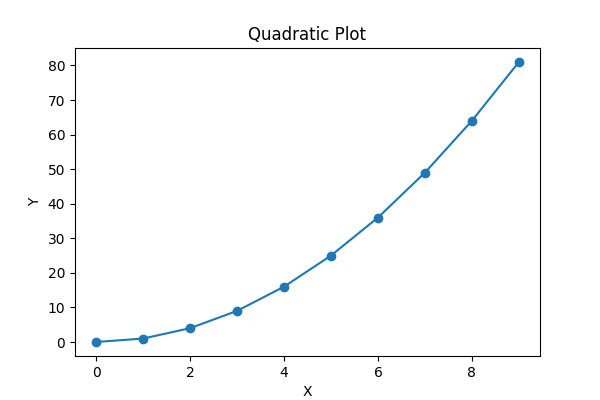

In [96]:
response.messages[1].content[1]